# PMI interview

## Test

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

Load libraries

In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
#from ggplot import *

In [3]:
set_plot_sizes(12,14,16)

## Load sales data

The data provided need to be copied (or linked) in the folder `data/`

In [4]:
PATH = "data/"

Read and load in memory the `sales_granular` dataset. This is the first step to understand how to design the target variable.

In [5]:
df_raw = pd.read_csv(f'{PATH}sales_granular.csv', low_memory=False)

In [6]:
df_raw.head()

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN
4,10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Convert the data from wide to long format

In [7]:
df_melt = pd.melt(df_raw, id_vars='store_code', var_name='time', value_name='volume')

Split the columns to have date and hour. Moreover column date recognized as `datetime`.

In [8]:
%time df_melt['date'], df_melt['hour'] = df_melt['time'].str.split(' ',1).str
#df_melt['date'] = pd.to_datetime(df_melt.date, infer_datetime_format= True)

CPU times: user 26.6 s, sys: 1.6 s, total: 28.2 s
Wall time: 27.7 s


In [13]:
#os.makedirs('tmp', exist_ok=True)
#df_melt.to_feather('tmp/sales_granular-long')

### EDA

Check how many missing values per store and day.

In [9]:
# Selecting only fields to be summarized
flds = ['store_code', 'date', 'volume']
group_flds = ['store_code','date']

In [65]:
def summary_per_day(x):
    d = {}
    volume = x['volume']
    d['volume_day'] = volume.sum()
    d['volume_nan'] = volume.isnull().sum()
    d['volume_n'] = len(volume)
    return pd.Series(d, index=['volume_day', 'volume_nan', 'volume_n'])

df_aggregate_per_day = df_melt[flds].groupby(group_flds).apply(summary_per_day).reset_index()

In [66]:
df_aggregate_per_day['date'] = pd.to_datetime(df_aggregate_per_day.date, infer_datetime_format= True)

NameError: name 'T' is not defined

In [67]:
df_aggregate_per_day.sort_values(['store_code','date'],inplace=True)

In [ ]:
df_aggregate_per_day['Perc_nan'] = df_aggregate_per_day['volume_nan']/df_aggregate_per_day['volume_n']
plt.hist(df_aggregate_per_day.Perc_nan, bins=50);

The majority are missing values. Need to investigate if it is by shop or in general.

In [17]:
def summary_per_shop(x):
    d = {}
    volume = x['volume_day']
    nan_perc = x['Perc_nan']
    d['volume_total'] = volume.sum()
    d['count_volumn_day_not_nan'] = (nan_perc != 1).sum()
    d['days_available'] = len(volume)
    return pd.Series(d, index=['volume_total', 'count_volumn_day_not_nan','days_available'])

df_aggregate_per_shop = df_aggregate_per_day.groupby('store_code').apply(summary_per_shop).reset_index()

In [19]:
df_aggregate_per_shop.head()

,store_code,volume_total,count_volumn_day_not_nan,days_available
0,249,18450.0,68.0,693.0
1,282,2880.0,29.0,693.0
2,425,810.0,10.0,693.0
3,1326,185340.0,341.0,693.0
4,1498,360.0,3.0,693.0


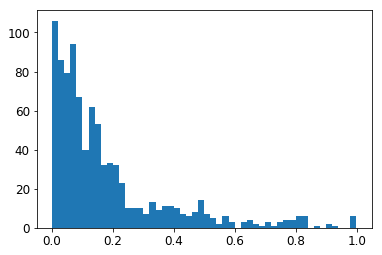

In [31]:
df_aggregate_per_shop['days_sell'] = df_aggregate_per_shop['count_volumn_day_not_nan']/df_aggregate_per_shop['days_available']

plt.hist(df_aggregate_per_shop.days_sell, bins=50);


In [29]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

#display_all(df_aggregate_per_shop.tail().T)

df_aggregate_per_shop.sort_values('days_sell')

,898,899,900,901,902
store_code,84223.000000,84351.000000,84608.000000,84658.000000,85011.000000
volume_total,5910.000000,10980.000000,263220.000000,6660.000000,22950.000000
count_volumn_day_not_nan,72.000000,43.000000,507.000000,64.000000,103.000000
days_available,693.000000,693.000000,693.000000,693.000000,693.000000
days_sell,0.103896,0.062049,0.731602,0.092352,0.148629


,store_code,volume_total,count_volumn_day_not_nan,days_available,days_sell
62,11007,60.0,1.0,693.0,0.001443
16,3745,30.0,1.0,693.0,0.001443
750,32357,300.0,1.0,693.0,0.001443
21,4032,30.0,1.0,693.0,0.001443
494,26906,60.0,2.0,693.0,0.002886
15,3655,90.0,2.0,693.0,0.002886
566,28634,90.0,2.0,693.0,0.002886
195,19717,600.0,2.0,693.0,0.002886
396,24356,90.0,2.0,693.0,0.002886
190,19506,60.0,2.0,693.0,0.002886


Thus, the dataset contains several shops where less than 20% of the data are missing. For example there are 4 shopw with only one day of volume information.

In [49]:
test = df_raw[df_raw.store_code == 11007]
test = test.drop('store_code', axis = 1)
test = test.values
test[np.isnan(test) == False]

array([30., 30.])

In [52]:
df_melt[(df_melt.store_code == 11007) & (np.isnan(df_melt.volume) == False)]

,store_code,time,volume,date,hour
10753344,11007,6/22/17 12:00,30.0,6/22/17,12:00
10754250,11007,6/22/17 13:00,30.0,6/22/17,13:00


#### First choice: aggregate by day
As a first step we drop the information about hour, since we have sparse data.

Since several shop have short time series of sell, we delete all days before first sell and last sell.
Ideally having the info about the time activity of the shop, or distribution time to that specific shop would help.

In [100]:
def take_informative_series(x):
    x = x.loc[x[(x.volume_day != 0)].first_valid_index():]
    x = x.loc[:x[(x.volume_day != 0)].last_valid_index()]
    return x

df_aggregate_per_day_short = df_aggregate_per_day.groupby('store_code').apply(take_informative_series).reset_index(drop = True)

Add information about days.

In [101]:
add_datepart(df_aggregate_per_day_short, 'date', drop=False)

In [115]:
??add_datepart

In [110]:
df_aggregate_per_day_short.head()

,store_code,date,volume_day,volume_nan,volume_n,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,249,2016-12-13,300.0,17.0,18.0,2016,12,50,13,1,348,False,False,False,False,False,False,1481587200
1,249,2016-12-14,0.0,18.0,18.0,2016,12,50,14,2,349,False,False,False,False,False,False,1481673600
2,249,2016-12-15,0.0,18.0,18.0,2016,12,50,15,3,350,False,False,False,False,False,False,1481760000
3,249,2016-12-16,0.0,18.0,18.0,2016,12,50,16,4,351,False,False,False,False,False,False,1481846400
4,249,2016-12-17,0.0,19.0,19.0,2016,12,50,17,5,352,False,False,False,False,False,False,1481932800


In [125]:
# Check if any days are closed for all the shops.
flds = ['store_code','volume_day','Dayofweek']

def summary_per_day(x):
    d = {}
    d['num_shops'] = x['store_code'].nunique()
    d['volumetot'] = x.volume_day.sum()
    return pd.Series(d, index=['num_shops', 'volumetot'])

df_aggregate_per_day_short_nozeros = df_aggregate_per_day_short[df_aggregate_per_day_short.volume_day!=0]
df_aggregate_per_day_short_nozeros[flds].groupby('Dayofweek').apply(summary_per_day)

,num_shops,volumetot
Dayofweek,,
0,858.0,9783930.0
1,863.0,9640680.0
2,855.0,9933930.0
3,866.0,10144650.0
4,872.0,12146550.0
5,847.0,10351530.0
6,482.0,3394680.0


There is no day where all shops are closed. But on Sundays (`Dayofweek == 6`) we have less shops open and thus less volume.

## Load metadata

In [127]:
md_raw = pd.read_json(f'{PATH}Surroundings.json')

In [128]:
md_raw.head()

,store_code,surroundings
0,10055,"{'subway_station': [], 'department_store': [],..."
1,10077,"{'subway_station': [], 'department_store': [],..."
2,10079,"{'subway_station': [], 'department_store': [{'..."
3,10086,"{'subway_station': [], 'department_store': [],..."
4,10111,"{'subway_station': [], 'department_store': [],..."


For each store we have a dictonary with similar keys of surrounding. Convert from wide to long.

In [147]:
def dict_to_df(x):
    d = x.surroundings
    return  pd.Series(pd.DataFrame(list(d.items())), index=list(d.keys())) 

In [198]:
df_surroundings = md_raw['surroundings'].apply(pd.Series)
md_long = pd.concat([md_raw.drop(['surroundings'], axis=1), df_surroundings], axis=1)

In [199]:
md_long.head()

,store_code,accounting,airport,amusement_park,aquarium,art_gallery,atm,bakery,bank,bar,...,store,subway_station,synagogue,taxi_stand,train_station,transit_station,travel_agency,university,veterinary_care,zoo
0,10055,[{'name': 'Fiduciaire Exacte & Gestion Comptab...,[],[],[],"[{'website': 'http://www.onegeeinfog.com/', 'n...","[{'website': 'https://www.ubs.com/ch/fr.html',...","[{'name': 'Mconseils SA', 'place_id': 'ChIJRz1...","[{'website': 'http://www.ubs.ch/', 'rating': 5...","[{'rating': 3.5, 'place_id': 'ChIJ8xHdm_1vjEcR...",...,[{'website': 'https://filialen.migros.ch/de/mi...,[],[],[],[],"[{'name': 'Chêne-Bourg, La Mousse', 'place_id'...","[{'name': 'Courir au Népal Sàrl', 'place_id': ...",[],[{'website': 'http://www.vet-chene-bougeries.c...,[]
1,10077,[],[],[],[],[],[],"[{'rating': 4.8, 'place_id': 'ChIJM8FbQe9vjEcR...",[],[],...,[{'website': 'http://www.coop.ch/fr/services/a...,[],[],[],[],"[{'name': 'Chêne-Bougeries, Montagne', 'place_...",[],[],[],[]
2,10079,[{'website': 'http://www.vd.ch/autorites/depar...,[],[],[],[],"[{'name': 'PickPost-Stelle', 'opening_hours': ...",[{'website': 'https://filialen.migros.ch/de/ta...,"[{'website': 'https://www.ubs.com/ch/fr.html',...",[{'website': 'https://www.facebook.com/Highlan...,...,"[{'website': 'http://www.denner.ch/', 'rating'...",[],[],[],[],"[{'name': 'Yverdon-les-Bains, Bel-Air', 'place...","[{'website': 'http://www.hotelplan.ch/FR/', 'r...",[],[],[]
3,10086,[],[],[],[],[],[],[],[],"[{'website': 'http://www.oubangui.com/', 'rati...",...,"[{'rating': 3.3, 'place_id': 'ChIJUW-HLeAxjEcR...",[],[],[],[],"[{'name': 'Bois-Gentil', 'place_id': 'ChIJK8fw...",[],[],[],[]
4,10111,[],[],[],[],[],[],[],[],[],...,"[{'name': 'lookemontre.com', 'opening_hours': ...",[],[],[],[],"[{'name': 'Yverdon-les-Bains, Plaisance', 'pla...",[],[],[],[]


In [211]:
empty_ = df_surroundings.apply(lambda x: x.astype(str) != '[]', axis=0)

In [251]:
surrondings_tpye_summary = empty_.sum(axis = 0)
surrondings_tpye_summary = pd.DataFrame({'type':surrondings_tpye_summary.index, 'count':surrondings_tpye_summary.values}) 

surrondings_store_summary = empty_.sum(axis = 1)
surrondings_store_summary = pd.DataFrame({'store_code':surrondings_store_summary.index, 'count':surrondings_store_summary.values}) 


Distribution of number of shops for each types of surroundings

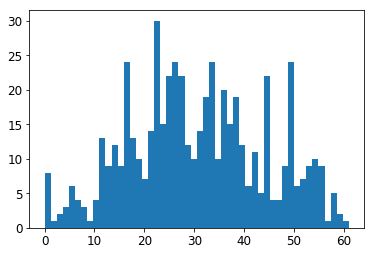

In [259]:
plt.hist(surrondings_store_summary['count'], bins = 50);
#plt.axvline(x=10, color = 'red');

Distribution of number of surroundings for each shop

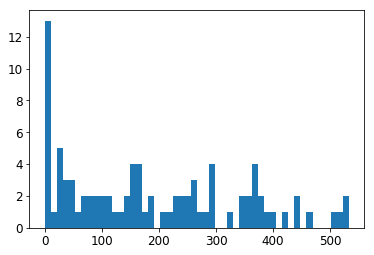

In [254]:
plt.hist(surrondings_tpye_summary['count'], bins = 50);

In [574]:
surrounding_keys = [set().union(*(d.keys() 
                                  for d in list(chain(*df_surroundings[i])))) 
                    for i in list(df_surroundings.columns)]
#unlist(list(md_long.accounting))
all_keys = set().union(*(list(x) for x in surrounding_keys))
all_keys

{0,
 'address_components',
 'formatted_address',
 'icon',
 'international_phone_number',
 'latitude',
 'longitude',
 'name',
 'opening_hours',
 'place_id',
 'price_level',
 'rating',
 'reviews',
 'types',
 'user_ratings_total',
 'website'}

As first pass we select only specific elements as possible features:

* `opening_hours`
* `rating`
* `types`
* `user_ratings_total`

At first we do not consider the single `reviews`.

### Check opening hours

In [575]:
surrounding_keys_list = [list(x) for x in surrounding_keys]

In [623]:
def get_first_type_with_feat(feature):
    filtered = [feature in x for x in surrounding_keys_list]
    return np.where(filtered)[0][0]

def get_example_feat(feat):
    series = df_surroundings.iloc[:,get_first_type_with_feat(feat)]
    elements = [x for x in series.tolist() if x]
    elements = [item for sublist in elements for item in sublist]
    elements_with_key = [{k: d[k] for k in [feat] if k in d} for d in elements]
    elements_with_key = list(filter(None, elements_with_key))
    return elements_with_key[0][feat]

In [624]:
fld = 'opening_hours'
test = get_example_feat(fld)
test

{'open_now': False,
 'periods': [{'close': {'day': 1, 'time': '1700'},
   'open': {'day': 1, 'time': '0900'}},
  {'close': {'day': 2, 'time': '1700'}, 'open': {'day': 2, 'time': '0900'}},
  {'close': {'day': 3, 'time': '1700'}, 'open': {'day': 3, 'time': '0900'}},
  {'close': {'day': 4, 'time': '1700'}, 'open': {'day': 4, 'time': '0900'}},
  {'close': {'day': 5, 'time': '1700'}, 'open': {'day': 5, 'time': '0900'}}],
 'weekday_text': ['Monday: 9:00 AM – 5:00 PM',
  'Tuesday: 9:00 AM – 5:00 PM',
  'Wednesday: 9:00 AM – 5:00 PM',
  'Thursday: 9:00 AM – 5:00 PM',
  'Friday: 9:00 AM – 5:00 PM',
  'Saturday: Closed',
  'Sunday: Closed']}

In case of `opening_hours`, since we decided to work with aggregate per day, we select the open days of the week.
A function is needed to extract the necessary values

In [625]:
def get_open_days(dt):
    hours = dt['weekday_text']
    return np.where([x.split(': ',1)[1] != 'Closed' for x in hours])[0]

get_open_days(test)

array([0, 1, 2, 3, 4])

### Check rating

In [626]:
fld = 'rating'
test = get_example_feat(fld)
test

2.5

No function is needed to extract the rating value.

### Check types

In [627]:
fld = 'types'
test = get_example_feat(fld)
test

['accounting', 'finance', 'point_of_interest', 'establishment']

### Check user ratings total

In [630]:
fld = 'user_ratings_total'
test = get_example_feat(fld)
test

2